# Analysis

## Import Libraries

In [86]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

plt.rcParams.update({'font.size':20})
sns.set(style="whitegrid", font_scale=1.5)

DATA_PATH = "./raw_data"
CONTROL_PATH = os.path.join(DATA_PATH, "control")
CONDITION_PATH = os.path.join(DATA_PATH, "condition")
SCORES_FILE = "scores.csv"

## Read Data

In [2]:
scores_df = pd.read_csv(os.path.join(DATA_PATH, SCORES_FILE))
scores_df.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [3]:
def get_csv_files(path: str, full=True):
    return [os.path.join(path, f) if full else f for f in os.listdir(path) if f.endswith('.csv')]

ctrl_files = get_csv_files(CONTROL_PATH)
cond_files = get_csv_files(CONDITION_PATH)

## Utility Functions

In [4]:
def get_data_from_individual(file_path, func):
    df = pd.read_csv(file_path)
    return func(df)

### Sample Activity file

In [5]:
df_ctrl = pd.read_csv(cond_files[2])
df_ctrl.head()

,timestamp,date,activity
0,2003-06-12 10:30:00,2003-06-12,0
1,2003-06-12 10:31:00,2003-06-12,0
2,2003-06-12 10:32:00,2003-06-12,0
3,2003-06-12 10:33:00,2003-06-12,0
4,2003-06-12 10:34:00,2003-06-12,0


## Get low-res data

In [6]:
def get_mean_by_hour(df):
    df['hour'] = pd.to_datetime(df.timestamp).dt.hour
    return df[['hour', 'activity']].groupby('hour').agg('mean').activity

x = range(24)

df_conds = pd.DataFrame(columns=x)
for file in cond_files:
    df_conds.loc[len(df_conds)] = get_data_from_individual(file, get_mean_by_hour)
avg_cond = np.mean(df_conds, axis=0)

df_ctrls = pd.DataFrame(columns=x)
for file in ctrl_files:
    df_ctrls.loc[len(df_ctrls)] = get_data_from_individual(file, get_mean_by_hour)
avg_ctrl = np.mean(df_ctrls, axis=0)

## Compare samples to average

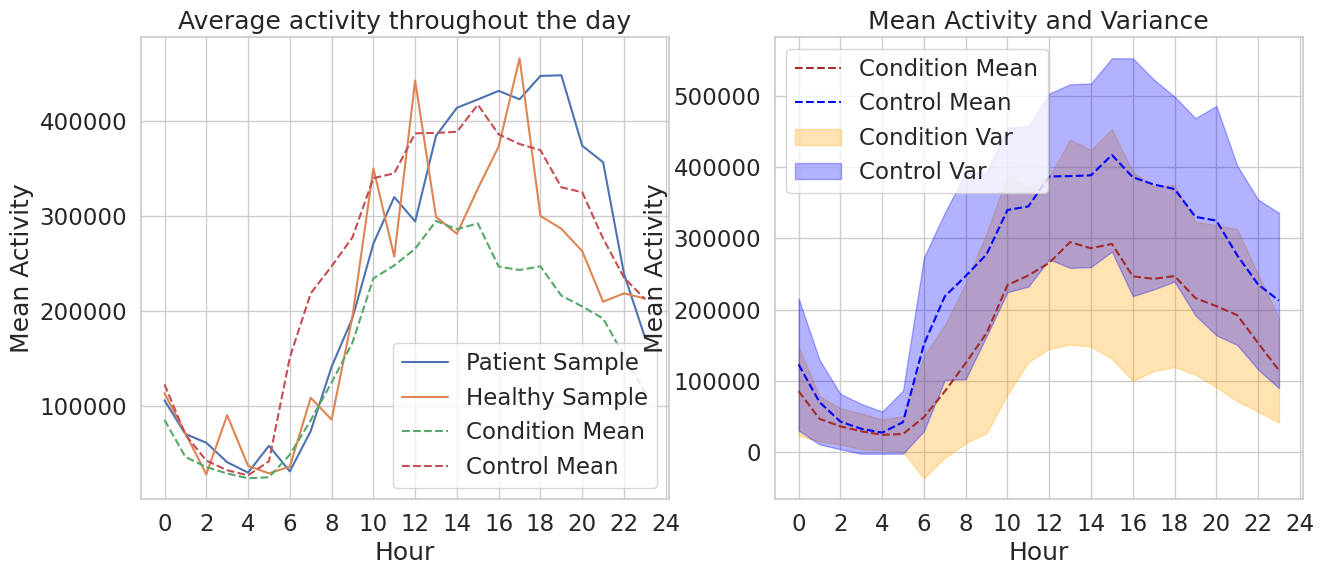

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = axes[0]
ax.plot(x, get_data_from_individual(cond_files[np.random.randint(len(cond_files))], get_mean_by_hour), label='Patient Sample')
ax.plot(x, get_data_from_individual(ctrl_files[np.random.randint(len(ctrl_files))], get_mean_by_hour), label='Healthy Sample')
ax.plot(x, avg_cond, label='Condition Mean', linestyle='--')
ax.plot(x, avg_ctrl, label='Control Mean', linestyle='--')
ax.locator_params(axis='x', nbins=24)
# Add labels and a legend
ax.set_xlabel('Hour')
ax.set_ylabel('Mean Activity')
ax.set_title('Average activity throughout the day', fontsize=18)
ax.legend()

ax = axes[1]
ax.plot(x, avg_cond, label='Condition Mean', linestyle='--', color='brown')
ax.plot(x, avg_ctrl, label='Control Mean', linestyle='--', color='blue')
ax.fill_between(x, avg_cond - np.sqrt(np.var(df_conds)), avg_cond + np.sqrt(np.var(df_conds)), color='orange', alpha=0.3, label='Condition Var')
ax.fill_between(x, avg_ctrl - np.sqrt(np.var(df_ctrls)), avg_ctrl + np.sqrt(np.var(df_ctrls)), color='blue', alpha=0.3, label='Control Var')

ax.locator_params(axis='x', nbins=24)
ax.set_title('Mean Activity and Variance')
ax.set_xlabel('Hour')
ax.set_ylabel('Mean Activity')
ax.legend()

plt.subplots_adjust(hspace=1)

# plt.savefig('fig3_fourlines.pdf')
# Show the plot
plt.show()

### Individual

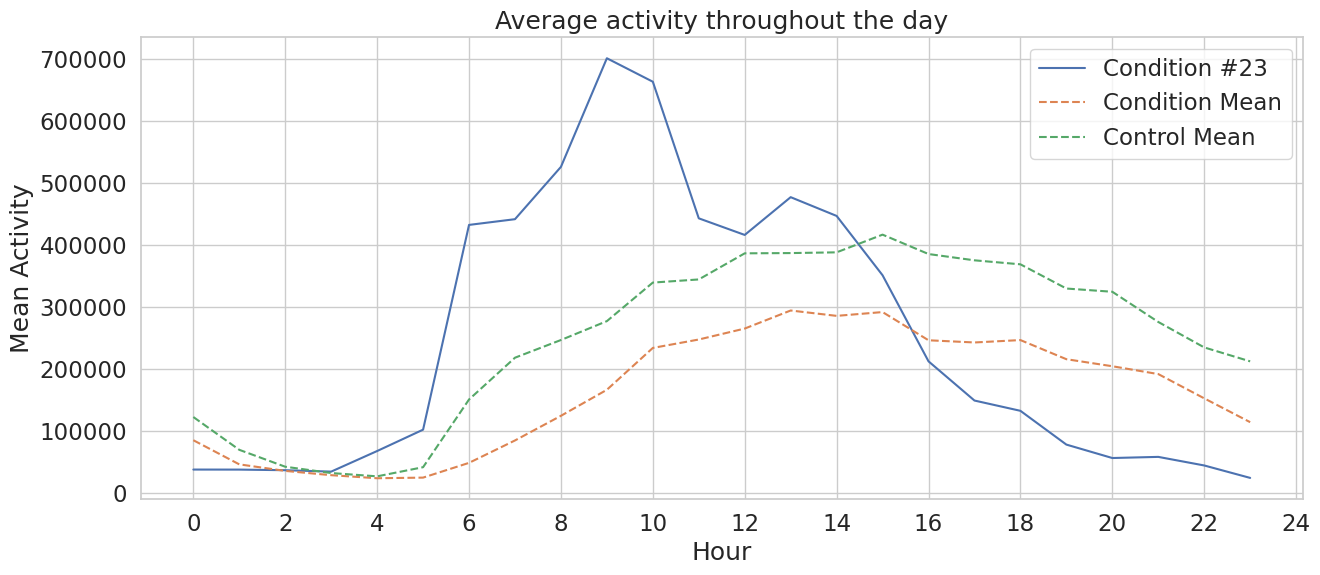

In [59]:
plt.figure(figsize=(15, 6))

plt.plot(x, get_data_from_individual(cond_files[22], get_mean_by_hour), label='Condition #23')
plt.plot(x, avg_cond, label='Condition Mean', linestyle='--')
plt.plot(x, avg_ctrl, label='Control Mean', linestyle='--')
plt.locator_params(axis='x', nbins=24)
# Add labels and a legend
plt.xlabel('Hour')
plt.ylabel('Mean Activity')
plt.title('Average activity throughout the day', fontsize=18)
plt.legend()

# plt.savefig('fig_cond23.pdf')
# Show the plot
plt.show()

## Extract features

In [68]:
ACTIVITY_THRESHOLD = 2000

def get_row_from_subject(df):
    df['date'] = pd.to_datetime(df.timestamp).dt.date
    df['hour'] = pd.to_datetime(df.timestamp).dt.hour
    df = df.drop(columns=['timestamp'])
    dha = df.groupby(['date', 'hour']).agg('sum')

    df_date_inactive = dha.groupby(['date']).apply(lambda x: np.sum(x.activity < ACTIVITY_THRESHOLD)).to_frame()
    df_date_inactive['Weekday'] = pd.to_datetime(df_date_inactive.index).day_name()
    df_weekday_avg = df_date_inactive.groupby(['Weekday']).agg('mean').reset_index()

    val1 = df_weekday_avg[df_weekday_avg.Weekday.isin(["Sunday", "Saturday"])].sum()[0]
    val2 = df_weekday_avg[~df_weekday_avg.Weekday.isin(["Sunday", "Saturday"])].sum()[0]

    df_sum = dha.groupby(['date']).apply(lambda x: np.sum(x.activity)).to_frame()
    df_sum['Weekday'] = pd.to_datetime(df_sum.index).day_name()
    df_weekday_avg = df_sum.groupby(['Weekday']).agg('mean').reset_index()
    val3 = df_weekday_avg[df_weekday_avg.Weekday.isin(["Sunday", "Saturday"])].sum()[0]
    val4 = df_weekday_avg[~df_weekday_avg.Weekday.isin(["Sunday", "Saturday"])].sum()[0]
    return {"WeekendInactiveHours": val1, "WeekdayInactiveHours": val2, "WeekendMeanActivity": val3, "WeekdayMeanActivity": val4}

In [72]:
data = pd.DataFrame()
for file in cond_files + ctrl_files:
    new_df = pd.DataFrame([get_data_from_individual(file, get_row_from_subject)])
    data = pd.concat([data, new_df], ignore_index=True)
data.head()

,WeekendInactiveHours,WeekdayInactiveHours,WeekendMeanActivity,WeekdayMeanActivity
0,11.5,33.833333,625733.5,2.041564e+06
1,15.5,51.500000,632616.0,1.151909e+06
2,9.5,36.500000,536742.0,1.102141e+06
3,13.5,38.000000,552927.0,1.327698e+06
4,20.0,51.833333,784687.0,1.848443e+06


## Methods

### Classification

In [96]:
df = data
X = df
y = np.array([1] * len(cond_files) + [0] * len(ctrl_files))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.7272727272727273
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.25      0.40         4

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11



### Clustering

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


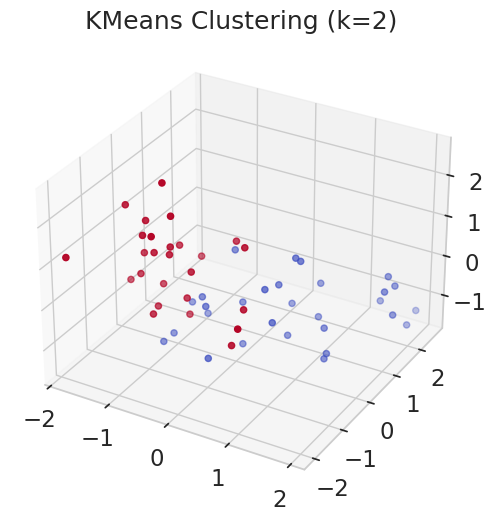

In [88]:
df = data
X = df
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster_2'] = kmeans.fit_predict(X_scaled)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=df['Cluster_2'], cmap='coolwarm')
ax1.set_title('KMeans Clustering (k=2)')

plt.savefig('fig_3d_kmeans.pdf')
plt.show()

#### t-SNE

/opt/software/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


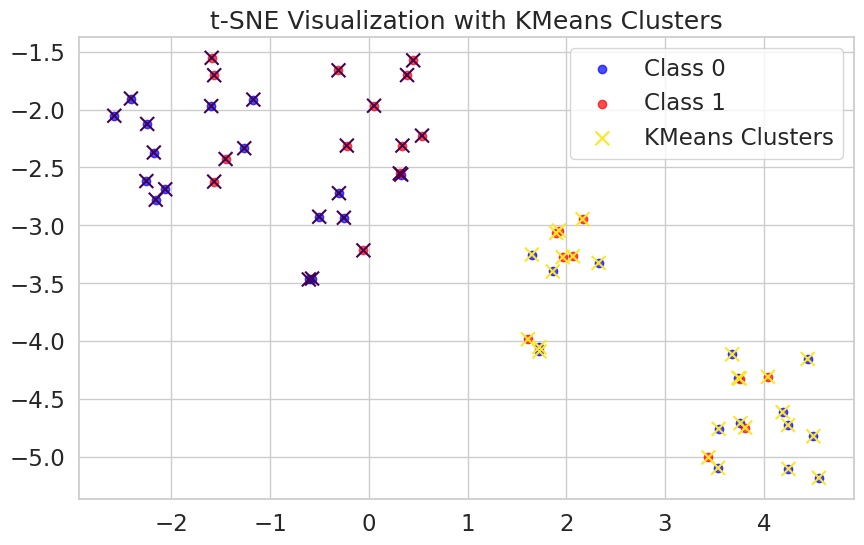

In [105]:
kmeans_labels = kmeans.fit_predict(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))

plt.scatter(X_tsne[y == 0][:, 0], X_tsne[y == 0][:, 1], c='blue', label='Class 0', alpha=0.7)
plt.scatter(X_tsne[y == 1][:, 0], X_tsne[y == 1][:, 1], c='red', label='Class 1', alpha=0.7)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='x', label='KMeans Clusters', s=100)

plt.title('t-SNE Visualization with KMeans Clusters')
plt.legend()

plt.savefig('fig_tsne.pdf')
plt.show()